In [25]:
import gensim
import numpy as np
import pandas as pd
import os
import re
import csv
import codecs
import sys
import pickle

from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from keras.utils import plot_model 
import gensim

from keras import callbacks
from keras import optimizers
from keras import models # simplify the following lines...


from keras.models import Sequential, Model, load_model
from keras.layers import Attention, Conv1D, MaxPooling1D, Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, Activation, Bidirectional
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences


import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
from keras.utils import plot_model 
from IPython.display import Image
import pydot
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import tensorflow as tf


from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from string import punctuation

from keras import backend as K
from keras.engine.topology import Layer
#from keras import initializations
from keras import initializers, regularizers, constraints


# Set golabl variables

In [18]:
DATA_DIR = 'data'
GloVe_PATH = 'data/glove.twitter.27B.50d.txt'
W2V_PATH = 'data/glove.50d.txt.word2vec' # dimension 50 w2v model
MAX_SENT_LEN = 150
MAX_VOCAB_SIZE = 40000
LSTM_DIM = 100
EMBEDDING_DIM = 50 # has to match dimension of w2v model (above)
BATCH_SIZE = 128
N_EPOCHS = 40

FILTER_LIST = '!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

SHOW_PRINTS = True

pd.set_option('display.max_colwidth', 500) # Set to -1 for no truncation.

# RESET RNG

np.random.seed(1)

# Load data

In [67]:

def load_data(data_dir = DATA_DIR, show_prints = SHOW_PRINTS):
    
    if show_prints == True:
        print('Loading data to dataframes...')
    
    train_content = pd.read_csv(os.path.join(data_dir,'train_bodies.csv'))
    train_stances = pd.read_csv(os.path.join(data_dir,'train_stances.csv'))
    test_content = pd.read_csv(os.path.join(data_dir,'competition_test_bodies.csv'))
    test_stances = pd.read_csv(os.path.join(data_dir,'competition_test_stances_unlabeled.csv'))
    
    if show_prints == True:
        print('Joining content and stance dataframes...')
    
    # would be better to replace only in the desired column, but whatever.
    
    train_stances.replace('unrelated',0,True)
    train_stances.replace('agree',1,True)
    train_stances.replace('disagree',2,True)
    train_stances.replace('discuss',3,True)
    
    train_combined = train_stances.join(train_content.set_index('Body ID'), on='Body ID')
    test_combined = test_stances.join(test_content.set_index('Body ID'), on='Body ID')
    
    if show_prints == True:
        print('Done.')
    
    
    
    return train_combined, test_combined




# Pre-processing 

In [4]:
# The following function returns two lists of lists of strings (tokens).
# The main point is to remove the filtered punctuation.
# Alternately, it is possible to feed the tokenizer lists of
# strings (the entire headline + body).
# This function takes longer to run than the tokenizer, though if
# you do things the alternate way, the tokenizer will also have to
# do this extra process of splitting the strings into single word strings
# which will add to the time that tokenizer() takes to run. The
# sequence_words() function seems to be fairly efficient anyway.


def sequence_words(train_combined, test_combined, show_prints = SHOW_PRINTS, filter_list = FILTER_LIST):
    
    if show_prints == True:
        print('Pairing headlines with bodies...')
    
    train_pairs = list(zip(*map(train_combined.get, ['Headline', 'articleBody'])))
    test_pairs = list(zip(*map(test_combined.get, ['Headline', 'articleBody'])))
    
    if show_prints == True:
        print('Creating word sequences...')
    
    #train_word_seqs = [text_to_word_sequence(pair[0] + ' ' + pair[1],filter_list) for pair in train_pairs]
    #test_word_seqs = [text_to_word_sequence(pair[0] + ' ' + pair[1],filter_list) for pair in test_pairs]
    
    train_word_seqs = []
    train_head_lengths = []
    
    for pair in train_pairs:
        head_word_seq = text_to_word_sequence(pair[0],filter_list)
        body_word_seq = text_to_word_sequence(pair[1],filter_list)
        train_word_seqs.append(head_word_seq + body_word_seq)
        train_head_lengths.append(len(head_word_seq))
    
    test_word_seqs = []
    test_head_lengths = []
    
    for pair in test_pairs:
        head_word_seq = text_to_word_sequence(pair[0],filter_list)
        body_word_seq = text_to_word_sequence(pair[1],filter_list)
        test_word_seqs.append(head_word_seq + body_word_seq)
        test_head_lengths.append(len(head_word_seq))
    
    
    if show_prints == True:
        print('Done.')
    
    return train_word_seqs, test_word_seqs, train_head_lengths, test_head_lengths


## Tokenization

In [5]:
def tokenize(word_seqs, show_prints = SHOW_PRINTS, filter_list = FILTER_LIST, max_vocab_size = MAX_VOCAB_SIZE):
    
    if show_prints == True:
        print('Tokenizing...')
    
    tokenizer = Tokenizer(num_words = max_vocab_size, filters = filter_list)
    tokenizer.fit_on_texts(word_seqs) # Why don't we just use the list of headline+body strings?
    
    if show_prints == True:
        print('Done.')
    
    return tokenizer

In [6]:
def wrangle_data(train_word_seqs, test_word_seqs, train_head_lengths, test_head_lengths, tokenizer, show_prints = SHOW_PRINTS, max_sent_len = MAX_SENT_LEN):
    
    if show_prints == True:
        print('Converting word sequences to integer sequences...')
    
    X_train = tokenizer.texts_to_sequences([' '.join(seq[:max_sent_len]) for seq in train_word_seqs])
    X_test = tokenizer.texts_to_sequences([' '.join(seq[:max_sent_len]) for seq in test_word_seqs])
    
    if show_prints == True:
        print('Creating padded arrays of integers...')
    
    X_train = pad_sequences(X_train, maxlen = max_sent_len, padding = 'post', truncating = 'post')
    X_test = pad_sequences(X_test, maxlen = max_sent_len, padding = 'post', truncating = 'post')
    
    if show_prints == True:
        print('Setting aside heading part of the arrays...')
    
    X_train_heads = []
    X_test_heads = []
    
    for i in range(len(X_train)): # len(myarray) is number of rows
        X_train_heads.append(list(X_train[i][:train_head_lengths[i]]))
    
    for i in range(len(X_test)): # len(myarray) is number of rows
        X_test_heads.append(list(X_test[i][:test_head_lengths[i]]))
    
    if show_prints == True:
        print('Done.')
    
    return X_train, X_test, X_train_heads, X_test_heads


# The following use of the LabelEncoder() is sort of overkill
# since y_transform will just end up being (more or less) the 
# transpose of y_train, up to permutation, depending on the
# order that the stances first appear in the corpus. This is
# because of the way we've replaced the "stance" values with
# 0,1,2, or 3. It would be fine to just keep them the same
# instead of possibly permuting them here with the label encoder...

In [7]:
def one_hot(y_train): # For some reason only works on first run, unless this function is redefined between runs.
    le = LabelEncoder()
    le.fit(y_train)
    y_transform = le.transform(y_train)
    one_hot = np_utils.to_categorical(y_transform)
    return one_hot


In [8]:
# The following function does all this stuff at once.

def prepare_data(data_dir = DATA_DIR, show_prints = SHOW_PRINTS, filter_list = FILTER_LIST, max_vocab_size = MAX_VOCAB_SIZE, max_sent_len = MAX_SENT_LEN):
    train_combined, test_combined = load_data(data_dir, show_prints)
    train_word_seqs, test_word_seqs, train_head_lengths, test_head_lengths = sequence_words(train_combined, test_combined, show_prints, filter_list)
    
    word_seqs = train_word_seqs + test_word_seqs
    head_lengths = train_head_lengths + test_head_lengths
    
    #tokenizer = tokenize(word_seqs, show_prints, filter_list, max_vocab_size)
    tokenizer = tokenize(word_seqs)
    
    X_train, X_test, X_train_heads, X_test_heads = wrangle_data(train_word_seqs, test_word_seqs, train_head_lengths, test_head_lengths, tokenizer, show_prints, max_sent_len)
    
    y_train = train_combined['Stance'].tolist()
    #one_hot = one_hot(y_train) # the one_hot() function only works on the first run
    # unless you rerun this cell, which redefines one_hot(). Works fine if you copy
    # the contents of the one_hot() function directly into the code, as below:
    
    le = LabelEncoder()
    le.fit(y_train)
    y_transform = le.transform(y_train)
    one_hot = np_utils.to_categorical(y_transform)
    
    # end of the one_hot() function...
    
    if show_prints == True:
        print('Done preparing data.')
    
    return X_train, X_test, X_train_heads, X_test_heads, one_hot, tokenizer
    

In [9]:
# Try doing it all at once:
X_train, X_test, X_train_heads, X_test_heads, one_hot, tokenizer = prepare_data()

Loading data to dataframes...
Joining content and stance dataframes...
Done.
Pairing headlines with bodies...
Creating word sequences...
Done.
Tokenizing...
Done.
Converting word sequences to integer sequences...
Creating padded arrays of integers...
Setting aside heading part of the arrays...
Done.
Done preparing data.


## Build embedding matrix

In [10]:
# Build model functions

# To create word2vec from glove file, use:
# glove2word2vec(GloVe_PATH, W2V_PATH)

def build_embeddings_matrix(tokenizer):
    global W2V_PATH, EMBEDDING_DIM
    
    embeddings = gensim.models.KeyedVectors.load_word2vec_format(W2V_PATH, binary=False)
    
    embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(tokenizer.word_index)+1, EMBEDDING_DIM)) # +1 is because the matrix indices start with 0
    for word, i in tokenizer.word_index.items(): # i=0 is the embedding for the zero padding
        try:
            embeddings_vector = embeddings[word]
        except KeyError:
            embeddings_vector = None
            #none: if words in sentence don't have pre-trained corresponding embedding, then error occurs

        if embeddings_vector is not None:
            embeddings_matrix[i] = embeddings_vector
            #if pre-trained word embedding exists，then let embeddings_matrix[i] is this embedding
            #Wi:the ith row of embeddings_matrix

    del embeddings
    return embeddings_matrix

# Build & Train model_1

In [14]:
def build_model_1(embeddings_matrix, tokenizer):
    global EMBEDDING_DIM, LSTM_DIM
    
    model_1 = Sequential()
    model_1.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                              output_dim=EMBEDDING_DIM,
                              weights = [embeddings_matrix], trainable=True, name='word_embedding_layer', #False
                              mask_zero=True))
    #mask_zero is to deal with padding problem
    #model.add(Bidirectional(LSTM(LSTM_DIM, return_sequences=False, name='lstm_layer1'))) #bi(lstm)
    model_1.add(Bidirectional(LSTM(LSTM_DIM, return_sequences=False, name='Bidrectional_lstm_layer1')))
    model_1.add(Dropout(rate=0.8, name='dropout_1')) # Can try varying dropout rates, in paper suggest 0.8
    model_1.add(Dense(4, activation='softmax', name='output_layer'))
    model_1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    
    return model_1

In [12]:
# The following function does the training and takes a really long time. 
# Should've added callbacks. Save after!!!

def train_model(model, X_train, one_hot, model_number = '1', save = True):
    global BATCH_SIZE, N_EPOCHS
    
    history = model.fit(X_train, one_hot,
          batch_size=BATCH_SIZE,
          epochs=N_EPOCHS,
          validation_split = 0.2)
    
    model_trained = model
    
    if save == True:
        model_trained.save('model_' + model_number) # saves as a directory with stuff in it
        #model_trained.save('model_' + model_number + 'as_file.h5') # saves as a single model file
    
    return model_trained, history

In [13]:
embeddings_matrix = build_embeddings_matrix(tokenizer)

In [15]:
model_1 = build_model_1(embeddings_matrix, tokenizer)

In [16]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, None, 50)          1681200   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               120800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
output_layer (Dense)         (None, 4)                 804       
Total params: 1,802,804
Trainable params: 1,802,804
Non-trainable params: 0
_________________________________________________________________


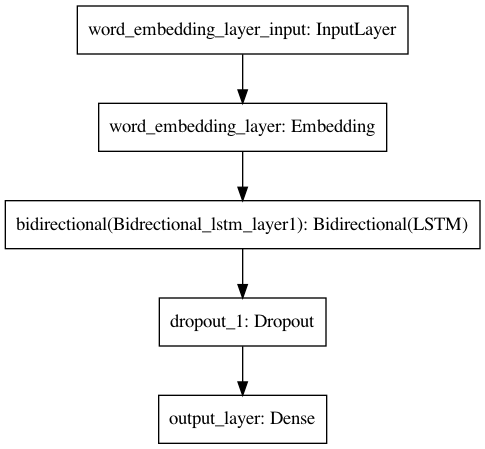

In [49]:
plot_model(model_1, to_file='model_1.png',show_shapes=False)

In [19]:
model_1_trained,history_1 = train_model(model_1, X_train, one_hot)

Epoch 1/40
313/313 [==============================] - 160s 513ms/step - loss: 0.7666 - accuracy: 0.7350 - val_loss: 0.6488 - val_accuracy: 0.7661
Epoch 2/40
313/313 [==============================] - 145s 462ms/step - loss: 0.6099 - accuracy: 0.7798 - val_loss: 0.5088 - val_accuracy: 0.8110
Epoch 3/40
313/313 [==============================] - 147s 468ms/step - loss: 0.4807 - accuracy: 0.8253 - val_loss: 0.4218 - val_accuracy: 0.8383
Epoch 4/40
313/313 [==============================] - 147s 469ms/step - loss: 0.4039 - accuracy: 0.8511 - val_loss: 0.3645 - val_accuracy: 0.8614
Epoch 5/40
313/313 [==============================] - 146s 468ms/step - loss: 0.3410 - accuracy: 0.8701 - val_loss: 0.3335 - val_accuracy: 0.8723
Epoch 6/40
313/313 [==============================] - 146s 467ms/step - loss: 0.2938 - accuracy: 0.8893 - val_loss: 0.2932 - val_accuracy: 0.8861
Epoch 7/40
313/313 [==============================] - 149s 477ms/step - loss: 0.2546 - accuracy: 0.9028 - val_loss: 0.2673 -

In [ ]:
LABELS = {'unrelated':0,'agree':1,'disagree':2,'discuss':3}

y_test_stances = pd.read_csv(os.path.join(DATA_DIR,'competition_test_stances.csv'))
y = y_test_stances['Stance']
y_test = []
for item in y:
    y_test.append(LABELS[item])

    

le = LabelEncoder()
le.fit(y_test)
y_transform = le.transform(y_test)
y_test_oh = np_utils.to_categorical(y_transform)
    

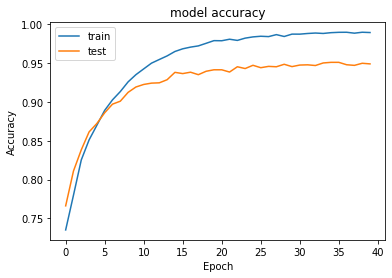

In [37]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Build & Train model_2

In [30]:

# attention layer is from: 
# https://stackoverflow.com/questions/62948332/how-to-add-attention-layer-to-a-bi-lstm/62949137#62949137
        
class Attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(Attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

In [31]:
def build_model_2(embeddings_matrix, tokenizer):

    global EMBEDDING_DIM, LSTM_DIM, MAX_SENT_LEN

    # Build a sequential model by stacking neural net units 
    # Dense layer: simply a layer connect units 
    # Dropout layer: for reduce overfitting a regularization methhod
    model_2 = Sequential()
    model_2.add(Embedding(input_dim=len(tokenizer.word_index)+1, input_length = MAX_SENT_LEN,
                              output_dim=EMBEDDING_DIM,
                              weights = [embeddings_matrix], trainable= True, name='word_embedding_layer', 
                              mask_zero=True)) # trainable=True results in overfitting

    model_2.add(LSTM(LSTM_DIM, return_sequences=True, name='lstm_layer')) # Can try Bidirectional-LSTM
    model_2.add(Dropout(rate=0.2, name='dropout_1')) # Can try varying dropout rates, in paper suggest 0.2
    #model.add(Activation(activation='relu', name='activation_1'))
    #output (batch_size, timesteps, input_dim)
    model_2.add(Attention(return_sequences = False))
    model_2.add(Dense(4, activation='softmax', name='output_layer'))
    
    model_2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
     
    return model_2

In [33]:
model_2 = build_model_2(embeddings_matrix, tokenizer)

In [34]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, 150, 50)           1681200   
_________________________________________________________________
lstm_layer (LSTM)            (None, 150, 100)          60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 100)          0         
_________________________________________________________________
attention (Attention)        (None, 100)               250       
_________________________________________________________________
output_layer (Dense)         (None, 4)                 404       
Total params: 1,742,254
Trainable params: 1,742,254
Non-trainable params: 0
_________________________________________________________________


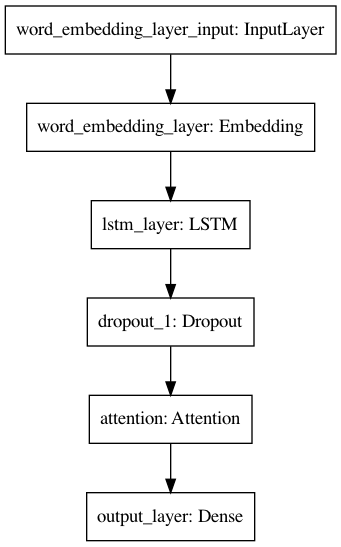

In [35]:
plot_model(model_2, to_file='model_2.png',show_shapes=False)

In [36]:
model_2_trained,history_2 = train_model(model_2, X_train, one_hot)

Epoch 1/40
313/313 [==============================] - 162s 518ms/step - loss: 0.7548 - accuracy: 0.7355 - val_loss: 0.6805 - val_accuracy: 0.7452
Epoch 2/40
313/313 [==============================] - 155s 496ms/step - loss: 0.5886 - accuracy: 0.7863 - val_loss: 0.5266 - val_accuracy: 0.8115
Epoch 3/40
313/313 [==============================] - 128s 408ms/step - loss: 0.4663 - accuracy: 0.8266 - val_loss: 0.4532 - val_accuracy: 0.8282
Epoch 4/40
313/313 [==============================] - 118s 378ms/step - loss: 0.3924 - accuracy: 0.8517 - val_loss: 0.4202 - val_accuracy: 0.8399
Epoch 5/40
313/313 [==============================] - 130s 414ms/step - loss: 0.3400 - accuracy: 0.8725 - val_loss: 0.3642 - val_accuracy: 0.8638
Epoch 6/40
313/313 [==============================] - 132s 422ms/step - loss: 0.2991 - accuracy: 0.8844 - val_loss: 0.3441 - val_accuracy: 0.8684
Epoch 7/40
313/313 [==============================] - 135s 431ms/step - loss: 0.2651 - accuracy: 0.8963 - val_loss: 0.2962 -

In [64]:
scoress = model_2_trained.evaluate(X_test, y_test_oh)
print("%s: %.2f%%"%(model_2_trained.metrics_names[1], scoress[1]*100))

795/795 [==============================] - 46s 58ms/step - loss: 2.8890 - accuracy: 0.6355
accuracy: 63.55%


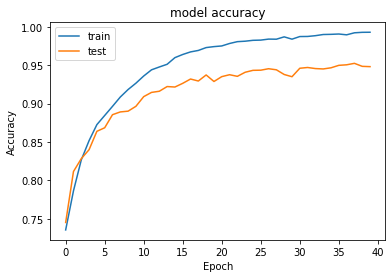

In [39]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

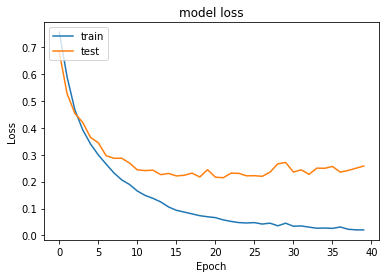

In [61]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [68]:
scoress = model_1_trained.evaluate(X_test, y_test_oh)
print("%s: %.2f%%"%(model_1_trained.metrics_names[1], scoress[1]*100))

795/795 [==============================] - 33s 41ms/step - loss: 2.0371 - accuracy: 0.6907
accuracy: 69.07%


In [50]:
def build_model_3(embeddings_matrix, tokenizer):

    global EMBEDDING_DIM, LSTM_DIM, MAX_SENT_LEN

    # Build a sequential model by stacking neural net units 
    # Dense layer: simply a layer connect units 
    # Dropout layer: for reduce overfitting a regularization methhod
    model_3 = Sequential()
    model_3.add(Embedding(input_dim=len(tokenizer.word_index)+1, input_length = MAX_SENT_LEN,
                              output_dim=EMBEDDING_DIM,
                              weights = [embeddings_matrix], trainable= True, name='word_embedding_layer', 
                              mask_zero=True)) # trainable=True results in overfitting
    model_3.add(Dropout(0.2))
    model_3.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'))
    model_3.add(MaxPooling1D(pool_size=2))
    model_3.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model_3.add(MaxPooling1D(pool_size=2))
    model_3.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model_3.add(BatchNormalization())
    model_3.add(Dense(128, activation='relu'))
    model_3.add(Dense(64, activation='relu'))
    #modell.add(Dense(4, activation='softmax'))

    #model_3.add(LSTM(LSTM_DIM, return_sequences=True, name='lstm_layer')) # Can try Bidirectional-LSTM
    #model_3.add(Dropout(rate=0.8, name='dropout_1')) # Can try varying dropout rates, in paper suggest 0.2
    #model.add(Activation(activation='relu', name='activation_1'))
    #output (batch_size, timesteps, input_dim)
    #model_3.add(Attention())
    model_3.add(Dense(4, activation='softmax', name='output_layer'))
    model_3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

    return model_3

In [51]:
def train_model(model, X_train, one_hot, model_number = '1', save = True):
    global BATCH_SIZE
    
    history = model.fit(X_train, one_hot,
          batch_size=BATCH_SIZE,
          epochs=5,
          validation_split = 0.2)
    
    model_trained = model
    
    if save == True:
        model_trained.save('model_' + model_number) # saves as a directory with stuff in it
        #model_trained.save('model_' + model_number + 'as_file.h5') # saves as a single model file
    
    return model_trained, history

In [53]:
model_3 = build_model_3(embeddings_matrix, tokenizer)

In [54]:
model_3_trained,history_3 = train_model(model_3, X_train, one_hot)

Epoch 1/5
313/313 [==============================] - 113s 362ms/step - loss: 0.7989 - accuracy: 0.7232 - val_loss: 0.7744 - val_accuracy: 0.7330
Epoch 2/5
313/313 [==============================] - 114s 365ms/step - loss: 0.6855 - accuracy: 0.7479 - val_loss: 0.7125 - val_accuracy: 0.6807
Epoch 3/5
313/313 [==============================] - 95s 304ms/step - loss: 0.5636 - accuracy: 0.7829 - val_loss: 0.6476 - val_accuracy: 0.7289
Epoch 4/5
313/313 [==============================] - 98s 313ms/step - loss: 0.4700 - accuracy: 0.8159 - val_loss: 0.4837 - val_accuracy: 0.8237
Epoch 5/5
313/313 [==============================] - 98s 314ms/step - loss: 0.4063 - accuracy: 0.8410 - val_loss: 0.4572 - val_accuracy: 0.8138
INFO:tensorflow:Assets written to: model_1/assets


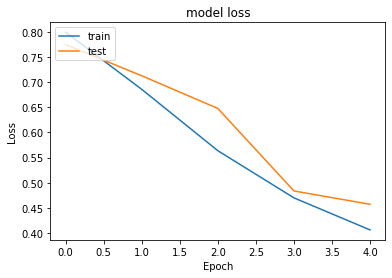

In [60]:
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction stage

In [56]:
def model_predict(model_trained, X_test, model_number = '1', csv = True):

    global DATA_DIR
    
    preds = model_trained.predict(X_test)
    outputs = [np.argmax(p) for p in preds]
    
    if csv == True:
        test_stances = pd.read_csv(os.path.join(DATA_DIR,'competition_test_stances_unlabeled.csv'))
    
        for i in range(len(outputs)):
            if outputs[i] == 0: outputs[i] = "unrelated"
            if outputs[i] == 1: outputs[i] = "disagree"
            if outputs[i] == 2: outputs[i] = "agree"
            if outputs[i] == 3: outputs[i] = "discuss"
            
        df_predicted = {}
        df_predicted = pd.DataFrame({'Stance': outputs})
        result = pd.concat([test_stances, df_predicted], axis=1, sort=False)
        result.to_csv('data/model_' + model_number + '_preds.csv', index=False, encoding='utf-8')
    
    return result

In [58]:
result_3 = model_predict(model_3_trained, X_test, model_number = '3', csv = True)